In [1]:

# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder


In [2]:
# 2. Load dataset
data = pd.read_csv("GaltonFamilies.csv")


Multiple Linear Regression
Coefficients: [0.41173112 0.29846253 5.27893245]
Intercept: 16.40014608006566
R²: 0.6132705128387651
MSE: 4.60780293206834


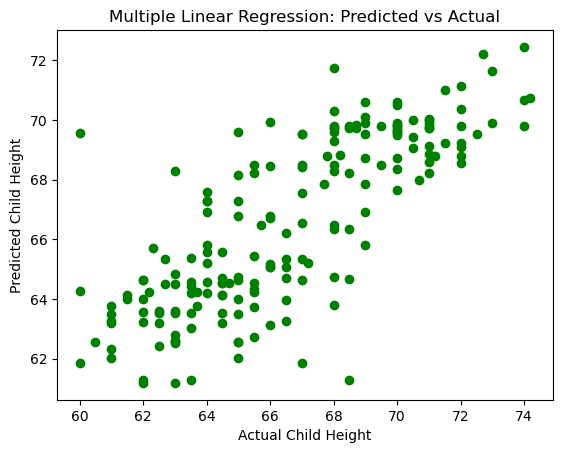

In [ ]:
# Encode categorical gender
data_encoded = data.copy()
le = LabelEncoder()
data_encoded["gender"] = le.fit_transform(data_encoded["gender"])  # male=1, female=0

# Use multiple features
X_multi = data_encoded[["father", "mother", "gender"]]
y_multi = data_encoded["childHeight"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)

# Train model
multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

# Predict
y_pred_multi = multi_model.predict(X_test)

# Evaluate
print("\nMultiple Linear Regression")
print("Coefficients:", multi_model.coef_)
print("Intercept:", multi_model.intercept_)
print("R²:", r2_score(y_test, y_pred_multi))
print("MSE:", mean_squared_error(y_test, y_pred_multi))

# Compare predicted vs actual
plt.scatter(y_test, y_pred_multi, color="green")
plt.xlabel("Actual Child Height")
plt.ylabel("Predicted Child Height")
plt.title("Multiple Linear Regression: Predicted vs Actual")
plt.show()

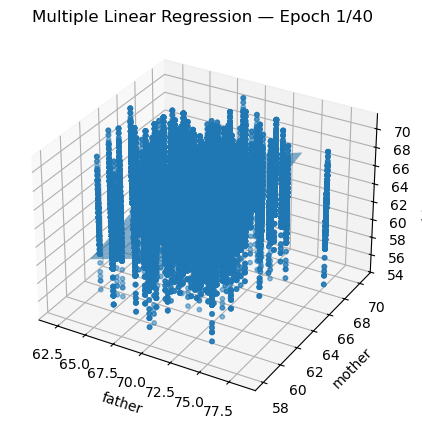

In [4]:
# ===== Multiple Linear Regression: SGD + animated plane (stable) =====
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

# --- Map gender strings to numeric (male=1, female=0) if needed ---
if 'gender' in data.columns:
    gender_map = {"male": 1, "m": 1, "man": 1, "boy": 1,
                  "female": 0, "f": 0, "woman": 0, "girl": 0}
    gnum = (data["gender"].astype(str).str.strip().str.lower().map(gender_map))
    if gnum.isna().any():
        unmapped = sorted(set(data["gender"].astype(str)) - set(gender_map.keys()))
        raise ValueError(f"Unmapped gender values found: {unmapped}. Update gender_map.")
    data["_gender_num"] = gnum.astype(float)

# --- Data (Galton if present; else synthetic) ---
use_galton = ('data' in globals()
              and {'father','mother','_gender_num','childHeight'}.issubset(set(data.columns)))
if use_galton:
    X_m_raw = data[['father','mother','_gender_num']].to_numpy().astype(float)
    y_m = data['childHeight'].to_numpy().astype(float).reshape(-1, 1)
else:
    rng = np.random.RandomState(0)
    n = 400
    father = rng.normal(69, 3, size=n)
    mother = rng.normal(64, 3, size=n)
    gender = rng.randint(0, 2, size=n)
    b0_true, bf_true, bm_true, bg_true = 20.0, 0.35, 0.45, 4.0
    child = b0_true + bf_true*father + bm_true*mother + bg_true*gender + rng.normal(0, 1.8, size=n)
    X_m_raw = np.c_[father, mother, gender]
    y_m = child.reshape(-1, 1)

# --- Standardize features (each column). Keep y in original units. ---
x_scaler_m = StandardScaler()
X_m = x_scaler_m.fit_transform(X_m_raw)

sgd_m = SGDRegressor(
    loss="squared_error",
    penalty=None,
    alpha=0.0,
    learning_rate="constant",
    eta0=0.01,
    max_iter=1,
    tol=None,
    random_state=0,
    warm_start=True,
    average=True
)

epochs = 40
coef_hist_m, intercept_hist_m = [], []

rng = np.random.RandomState(1)
for epoch in range(epochs):
    idx = rng.permutation(len(X_m))
    sgd_m.partial_fit(X_m[idx], y_m[idx].ravel())

    # y = a^T z + b,  z = (x - mu)/sigma  (elementwise)
    a = sgd_m.coef_.astype(float)   # shape (3,)
    b = float(sgd_m.intercept_[0])

    # Convert to original units:
    # slope_i = a_i / sigma_i
    # intercept = b - sum_i a_i * mu_i / sigma_i
    slopes = a / x_scaler_m.scale_
    intercept = b - np.sum(a * x_scaler_m.mean_ / x_scaler_m.scale_)

    coef_hist_m.append(slopes)          # in original units
    intercept_hist_m.append(intercept)

coef_hist_m = np.array(coef_hist_m)     # (epochs, 3)
intercept_hist_m = np.array(intercept_hist_m)

# --- Animate plane at fixed gender (0=female, 1=male) ---
gender_fixed = 0.0

f_min, f_max = np.percentile(X_m_raw[:,0], [2, 98])
m_min, m_max = np.percentile(X_m_raw[:,1], [2, 98])
F, M = np.meshgrid(
    np.linspace(f_min, f_max, 30),
    np.linspace(m_min, m_max, 30)
)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')
mask = (X_m_raw[:,2] == gender_fixed)
ax.scatter(X_m_raw[mask,0], X_m_raw[mask,1], y_m[mask], s=10, alpha=0.5,
           label=f"data (gender={int(gender_fixed)})")

# final reference plane (dashed look via low alpha)
final_a, final_b, final_g = coef_hist_m[-1]
final_c = intercept_hist_m[-1]
Z_ref = final_c + final_a*F + final_b*M + final_g*gender_fixed
ax.plot_surface(F, M, Z_ref, alpha=0.25)

surf = [None]

def init():
    ax.set_xlabel("father")
    ax.set_ylabel("mother")
    ax.set_zlabel("childHeight")
    ax.set_title(f"Multiple Linear Regression — Epoch 1/{epochs}")
    return []

def update(frame):
    if surf[0] is not None:
        for coll in surf[0]:
            coll.remove()
    a, b, g = coef_hist_m[frame]         # already in original units
    c = intercept_hist_m[frame]
    Z = c + a*F + b*M + g*gender_fixed
    new_surf = ax.plot_surface(F, M, Z, alpha=0.4, rstride=1, cstride=1)
    surf[0] = [new_surf]
    ax.set_title(f"Multiple Linear Regression — Epoch {frame+1}/{epochs}\n"
                 f"coef: [father={a:.3f}, mother={b:.3f}, gender={g:.3f}], intercept={c:.3f}")
    return surf[0]

ani = FuncAnimation(fig, update, frames=epochs, init_func=init, blit=False, interval=250)
HTML(ani.to_jshtml())
